In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [23]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]


# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

In [3]:
# Diane's Ages
pdfout = fits.getdata('LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

# PCA

In [45]:
# from sklearn.preprocessing import MinMaxScaler
data = np.array([parsec['logTe'],parsec['Ksmag'],np.log10(parsec['Zini']/0.02),parsec['logg']]).T

# scaler = MinMaxScaler()
# data_rescaled = scaler.fit_transform(data)

In [26]:
data_rescaled

array([[0.83357988, 0.21774467, 0.        , 0.46017015],
       [0.8125    , 0.20465064, 0.        , 0.44624903],
       [0.80362426, 0.19686195, 0.        , 0.43825728],
       ...,
       [0.02366864, 0.01693193, 1.        , 0.01985048],
       [0.00628698, 0.00428942, 1.        , 0.00489817],
       [0.        , 0.        , 1.        , 0.        ]])

In [46]:
pca = PCA(n_components = 0.99)
pca.fit(data)#_rescaled)
# reduced = pca.transform(data)#_rescaled)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

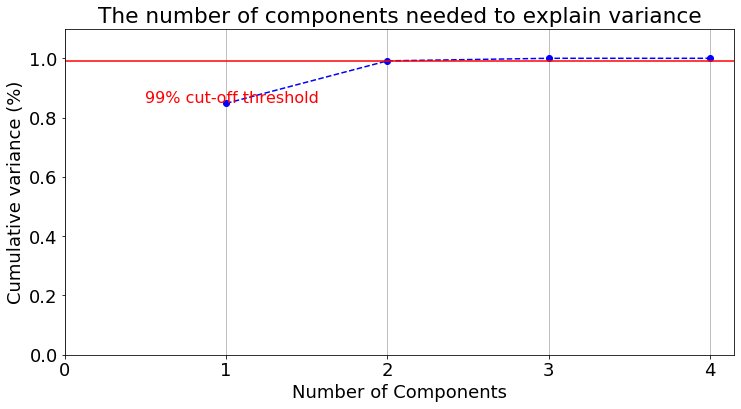

In [47]:
pca = PCA().fit(data)#_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [74]:
#transform data to new basis
new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables
x1 = new_data[:,0]
x2 = new_data[:,1]
x3 = new_data[:,2]
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x23 = np.multiply(x2,x3)
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2

#find all possible models
models = []
models_str = []
all_var_str = ['x1','x2','x3','x12','x13','x23','x1sq','x2sq','x3sq']
all_var = [x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq]
for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

In [75]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

all_params = []
max_resid = []
mads = []
resids = []
predict = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - parsec['logAge']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))

0.010404961539896007
['x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq']


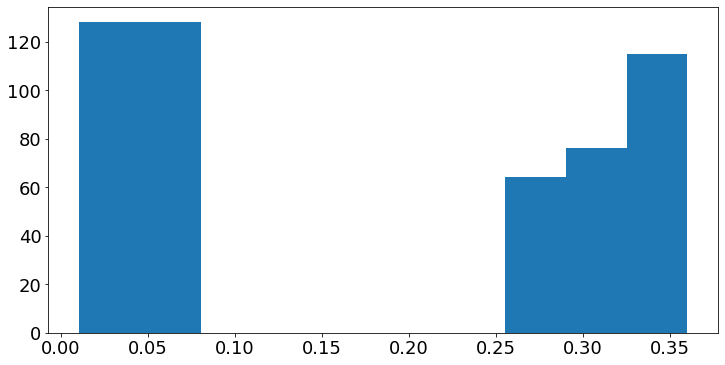

In [78]:
plt.hist(mads)
print(np.asarray(mads)[np.asarray(mads).argmin()])
print(models_str[np.asarray(mads).argmin()])

In [79]:
small = np.where(np.asarray(mads)<=0.05)

terms = []

for i in range(len(models_str[small])):
    terms.append(len(models_str[small][i]))
    
print(terms)
for j in range(7):
    print('index: ',np.arange(len(models_str))[small][j])
    print(models_str[small][j])
    
# print(fours)
# print((np.asarray(mads)[small][fours]).argmin())
# print(models_str[small][fours][(np.asarray(mads)[small][fours]).argmin()])

[2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9]
index:  10
['x1' 'x3']
index:  45
['x1' 'x2' 'x3']
index:  52
['x1' 'x3' 'x12']
index:  53
['x1' 'x3' 'x13']
index:  54
['x1' 'x3' 'x23']
index:  55
['x1' 'x3' 'x1sq']
index:  56
['x1' 'x3' 'x2sq']


In [80]:
parsimonious = np.array([x1,x3]).T #np.array([y1, y2, y3, y12, y13, y23, y1sq, y2sq, y3sq, y2cu]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 7.499e+05
Date:                Mon, 20 Apr 2020   Prob (F-statistic):               0.00
Time:                        01:03:04   Log-Likelihood:                 23454.
No. Observations:               16121   AIC:                        -4.690e+04
Df Residuals:                   16118   BIC:                        -4.688e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4129      0.000   2.12e+04      0.0

In [81]:
def find_ages(z1,z2):
    p = [9.41292724,0.05706436,-2.70513596]
    return p[0]+p[1]*z1+p[2]*z2

In [85]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_N.append(sol_xm[1]*10**(r13['N_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_O.append(sol_xm[2]*10**(r13['O_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_S.append(sol_xm[5]*10**(r13['S_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H'][i]-r13['M_H'][i]))
    
# facts = []
# factsalp = []
# factsCNO = []
factsCN = []
# factsCO = []
for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
#     numerCO = x_C[j]+x_O[j]
#     denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
# factsCO.append(numerCO/denomCO)
    
factsCN = factsCN
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

_, _, stardist = afunc.LMCdisk_cart(r13['RA'],r13['DEC'])
corabsK = afunc.absmag(r13['K'],stardist)-r13['AK_TARG']

adat = np.array([np.log10(r13['TEFF']),corabsK,afunc.sal(r13['M_H'],metscorr),r13['LOGG']]).T

zs = PCA(n_components=3).fit(data).transform(adat)

parage = find_ages(zs[:,0],zs[:,2])

(array([1.000e+00, 0.000e+00, 1.000e+00, 9.000e+00, 9.500e+01, 1.670e+02,
        6.340e+02, 1.583e+03, 9.600e+01, 2.000e+00]),
 array([ 3.59884845,  4.46824317,  5.33763788,  6.20703259,  7.07642731,
         7.94582202,  8.81521674,  9.68461145, 10.55400616, 11.42340088,
        12.29279559]),
 <a list of 10 Patch objects>)

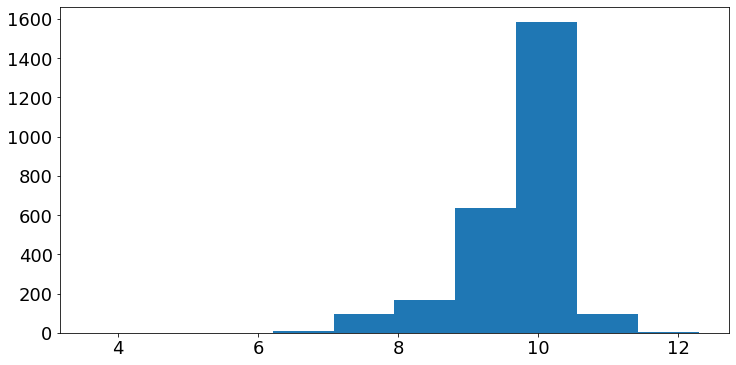

In [86]:
plt.hist(parage)

In [87]:
####################################
### Get Uncertainties: Add Noise ###
####################################

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

def sal_noise(cfe,cfeERR,nfe,nfeERR,feh,fehERR,mh,mhERR):
    '''
    Calculate noisy values for Salaris calculation with C and N.
    This does not take into account actually plugging in [M/H],
    for that use add_noise.
    
    Parameters:
        cfe: 1d array-like object of carbon abundances
        cfeERR: 1d array-like object of carbon abundance errors
        nfe: 1d array-like object of nitrogen abundances
        nfeERR: 1d array-like object of nitrogen abundance errors
        feh: 1d array-like object of iron abundances
        fehERR: 1d array-like object of iron abundance errors
        
    Return:
        noisy Salaris correction ffac
    '''
    
    sol_C = 0.28115244582676185 #solar carbon abundance
    sol_N = 0.06901474154376043 #solar nitrogen abundance
    
    # Calculate [C/M] and [N/M] with respective errors
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    # Calculate X fractions for C and N with respective errors
    x_C = sol_C*10**(cm)
    x_N = sol_N*10**(nm)
    
    x_CERR = 10**(cm)*np.log(10)*CMERR
    x_NERR = 10**(nm)*np.log(10)*NMERR
    
    # Calcuate f factor in Salaris correction with respective errors
    ffac = (x_C+x_N)/(sol_C+sol_N) #factor from Salaris correction
    ffacERR = np.sqrt((x_CERR)**2+(x_NERR)**2)/(sol_C+sol_N)
    
    # Add noise to calculated f factor
    ffacnoise = np.random.uniform(-np.absolute(0.434*(ffacERR/ffac)),np.absolute(0.434*(ffacERR/ffac))) 
    
    return ffac + ffacnoise

In [89]:
################################
### Calculate  Uncertainties ###
################################

devs = []
halo_cutoff = -1.53

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        if feh <= halo_cutoff:
            dist_new = add_noise(dist,1.0,distribution='uniform')
            absK_new = afunc.absmag(ks_new,dist_new) - ak
        
        else:
            absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new = np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]).T
        
        noise_ages.append(find_ages(new[0],new[2]))
    
    devs.append(afunc.mad(noise_ages))

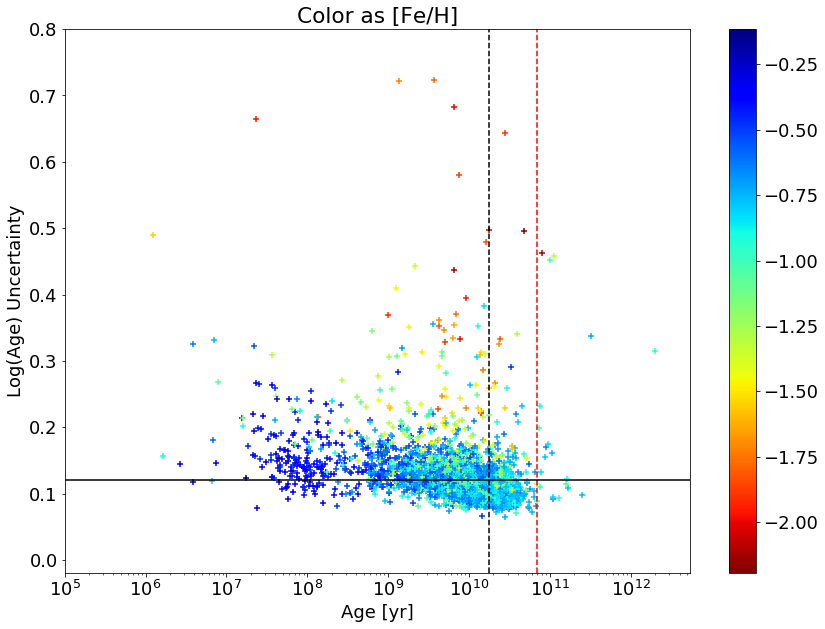

In [111]:
### Error Plot

mod_devs = np.asarray(devs)[np.where(np.asarray(devs)<1.16)]

plt.figure(figsize=[14,10])
plt.scatter(10**np.asarray(parage),devs,marker='+',c=r13['FE_H'],cmap='jet_r')
plt.colorbar()
plt.axvline(10**(np.log10(ageU)+np.median(devs)),c='k',ls='--')
plt.axvline(10**(np.log10(ageU)+np.max(mod_devs)),c='r',ls='--')
plt.axhline(np.median(devs),c='k')
plt.xscale('log')
plt.xlim(left=10**5)
plt.ylim(top=0.8)
plt.xlabel(r'Age [yr]')
plt.ylabel(r'Log(Age) Uncertainty')
plt.title(r'Color as [Fe/H]')
# plt.savefig('PCAOLS_uncert.pdf',bbox_inches='tight')
plt.show()

In [107]:
print('10.13 + median devs: ',len(np.squeeze(np.where(parage>=10.13+np.median(devs))))/len(parage)*100)
print('10.13 + max mod_devs: ',len(np.squeeze(np.where(parage>=10.13+np.max(mod_devs))))/len(parage)*100)

10.13 + median devs:  21.32921174652241
10.13 + max mod_devs:  0.7727975270479135


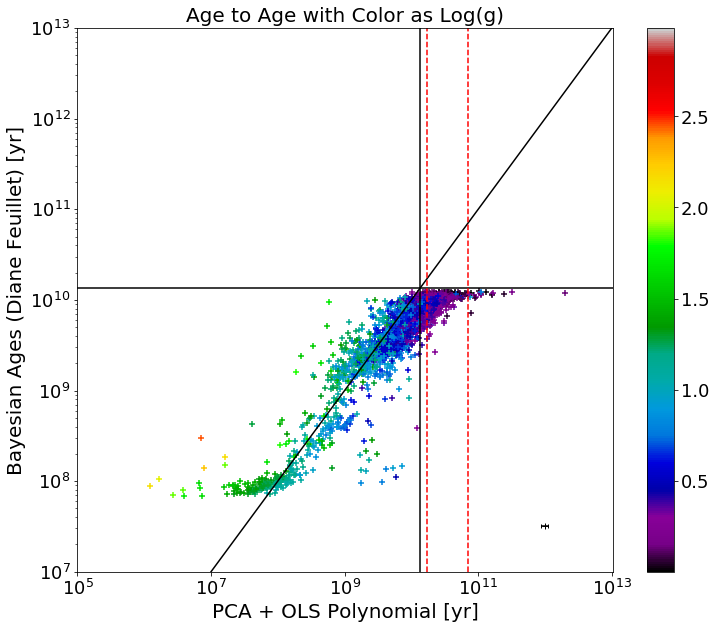

In [110]:
########################
### compare to Diane ###
########################

plt.figure(figsize=[12,10])
plt.scatter(10**parage[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
            marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**13)
plt.xlim(left=10**5)

# plt.scatter(10**12,10**7.5,c='k',marker='+')
plt.errorbar(10**12,10**7.5,xerr=np.sqrt((10**12)**2*(np.median(devs))**2),c='k',capsize=2,marker='+')

plt.axvline(10**10.13,c='k')
plt.axhline(10**10.13,c='k')
plt.axvline(10**(np.log10(ageU)+np.max(mod_devs)),c='r',linestyle='--')
plt.axvline(10**(np.log10(ageU)+np.median(mod_devs)),c='r',linestyle='--')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'PCA + OLS Polynomial [yr]',fontsize=20)
plt.ylabel(r'Bayesian Ages (Diane Feuillet) [yr]',fontsize=20)
plt.title(r'Age to Age with Color as Log(g)',fontsize=20)
# plt.savefig('age2age_PCA_OLS.pdf',bbox_inches='tight')
plt.show()